# 🔬 Hyperparameter Optimization Analysis

Analysis of the hyperparameter search performed in Colab training.

**Search Space:**
- Models: MobileNetV2, MobileNetV3-Small, EfficientNet-B0
- Learning Rates: 5e-4, 1e-3, 3e-3, 5e-3
- Batch Sizes: 32, 64

**Contents:**
1. Summary Table
2. Model Comparison
3. Learning Rate Effect per Model
4. Training Curves
5. Sample Predictions with Confidence


In [1]:

import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bold_striking') 
import seaborn as sns
from pathlib import Path
import torch
import torch.nn.functional as F
from PIL import Image
import mlflow

from src.cv_model.train import get_model
from src.cv_model.inference import get_inference_transform

# Paths
MODELS_DIR = Path('../models')
DATA_DIR = Path('../data/raw')
FIGURES_DIR = Path('../blog/figures')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MLflow setup
MLFLOW_TRACKING_URI = f"file:///{MODELS_DIR.absolute()}/mlruns"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

print(f"Device: {DEVICE}")
print(f"MLflow URI: {MLFLOW_TRACKING_URI}")


Device: cpu
MLflow URI: file:///c:\Users\fibla\Documents\Mano\notebooks\..\models/mlruns


## 1. Load All Experiment Results


In [2]:
# Load all experiments
all_runs = []

# Get all experiments
experiments = mlflow.search_experiments()
print(f"Found {len(experiments)} experiments:")
for exp in experiments:
    print(f"  - {exp.name} (ID: {exp.experiment_id})")

# Load runs from relevant experiments
for exp in experiments:
    if exp.name == "Default":  # Skip default experiment
        continue
    
    runs = mlflow.search_runs(experiment_ids=[exp.experiment_id])
    if not runs.empty:
        runs['experiment_name'] = exp.name
        all_runs.append(runs)
        print(f"  Loaded {len(runs)} runs from '{exp.name}'")

# Combine all runs
if all_runs:
    df_runs = pd.concat(all_runs, ignore_index=True)
    print(f"\nTotal runs loaded: {len(df_runs)}")
else:
    print("No runs found!")


Found 5 experiments:
  - V2_moredata (ID: 846159936519256748)
  - colab_mobilenet_v3_small (ID: 337235777032359844)
  - colab_efficientnet_b0 (ID: 210306776561890477)
  - colab_mobilenet_v2 (ID: 494931728678000044)
  - Default (ID: 0)


c:\Users\fibla\.local\share\mamba\envs\Mano\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


  Loaded 18 runs from 'V2_moredata'
  Loaded 1 runs from 'colab_mobilenet_v3_small'
  Loaded 1 runs from 'colab_efficientnet_b0'
  Loaded 2 runs from 'colab_mobilenet_v2'

Total runs loaded: 22


In [3]:
# Extract relevant columns and clean up
columns_map = {
    'params.model_name': 'model',
    'params.learning_rate': 'lr',
    'params.batch_size': 'batch_size',
    'metrics.best_val_loss': 'best_val_loss',
    'metrics.best_val_acc': 'best_val_acc',
    'metrics.test_acc': 'test_acc',
    'metrics.test_loss': 'test_loss',
    'run_id': 'run_id',
    'experiment_name': 'experiment'
}

# Filter columns that exist
available_cols = [c for c in columns_map.keys() if c in df_runs.columns]
df = df_runs[available_cols].copy()
df.columns = [columns_map[c] for c in available_cols]

# Convert types
if 'lr' in df.columns:
    df['lr'] = pd.to_numeric(df['lr'], errors='coerce')
if 'batch_size' in df.columns:
    df['batch_size'] = pd.to_numeric(df['batch_size'], errors='coerce').astype('Int64')

# Drop rows with missing essential data
df = df.dropna(subset=['model', 'lr', 'test_acc'])

print(f"Cleaned dataset: {len(df)} runs")
df.head()


Cleaned dataset: 21 runs


model       lr  batch_size  best_val_loss  best_val_acc  \
0  efficientnet_b0  0.00100          64      12.359782      0.036430   
1  efficientnet_b0  0.00100          32      15.608729      0.027322   
2  efficientnet_b0  0.00010          64     883.567718      0.038251   
3  efficientnet_b0  0.00010          32     930.760700      0.045537   
4  efficientnet_b0  0.00001          64    1118.234370      0.058288   

   test_acc    test_loss                            run_id   experiment  
0  0.025501    17.998680  d77fd4a0a0794195af9d9260a3c28405  V2_moredata  
1  0.067395    34.256117  8822eddea7cf4420b6c7895284250659  V2_moredata  
2  0.032787  1965.816628  878788e43ce6448eaf268c678d136470  V2_moredata  
3  0.030965  1653.035801  e8675991dfdd47a0b08687f573ca9df9  V2_moredata  
4  0.049180  1982.413706  7db4b40809ae41ff82f7eeb449bc5cc6  V2_moredata

## 2. Summary Table


In [4]:
# Create summary table sorted by test accuracy
summary = df[['model', 'lr', 'batch_size', 'best_val_loss', 'best_val_acc', 'test_acc']].copy()
summary = summary.sort_values('test_acc', ascending=False)

# Format for display
summary_display = summary.copy()
summary_display['lr'] = summary_display['lr'].apply(lambda x: f"{x:.0e}")
summary_display['best_val_loss'] = summary_display['best_val_loss'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else '-')
summary_display['best_val_acc'] = summary_display['best_val_acc'].apply(lambda x: f"{x:.2%}" if pd.notna(x) else '-')
summary_display['test_acc'] = summary_display['test_acc'].apply(lambda x: f"{x:.2%}" if pd.notna(x) else '-')

print("=" * 80)
print("HYPERPARAMETER SEARCH RESULTS (sorted by Test Accuracy)")
print("=" * 80)
print(summary_display.to_string(index=False))

# Best configuration
best = summary.iloc[0]
print(f"\n🏆 Best Configuration:")
print(f"   Model: {best['model']}")
print(f"   Learning Rate: {best['lr']:.0e}")
print(f"   Batch Size: {best['batch_size']}")
print(f"   Test Accuracy: {best['test_acc']:.2%}")


HYPERPARAMETER SEARCH RESULTS (sorted by Test Accuracy)
             model    lr  batch_size best_val_loss best_val_acc test_acc
      mobilenet_v2 1e-03          32             -      100.00%  100.00%
mobilenet_v3_small 1e-03          32             -      100.00%  100.00%
   efficientnet_b0 1e-03          32             -      100.00%   99.64%
      mobilenet_v2 1e-03          64        0.0323       99.09%   99.27%
      mobilenet_v2 1e-04          32        0.0897       97.81%   98.72%
      mobilenet_v2 1e-03          32        0.0855       96.90%   97.27%
      mobilenet_v2 1e-04          64        0.1698       95.26%   96.90%
mobilenet_v3_small 1e-03          32        0.5978       84.52%   84.52%
mobilenet_v3_small 1e-03          64        0.5354       82.33%   71.22%
      mobilenet_v2 1e-05          32        1.8104       65.03%   66.12%
mobilenet_v3_small 1e-04          32        1.2248       69.03%   45.17%
      mobilenet_v2 1e-05          64        2.4831       43.17%   41

In [5]:
# Best per model
print("\n📊 Best Configuration per Model:")
print("-" * 60)
best_per_model = summary.groupby('model').first().reset_index()
for _, row in best_per_model.iterrows():
    print(f"{row['model']:20} | LR: {row['lr']:.0e} | BS: {int(row['batch_size']):2} | Test: {row['test_acc']:.2%}")



📊 Best Configuration per Model:
------------------------------------------------------------
efficientnet_b0      | LR: 1e-03 | BS: 32 | Test: 99.64%
mobilenet_v2         | LR: 1e-03 | BS: 32 | Test: 100.00%
mobilenet_v3_small   | LR: 1e-03 | BS: 32 | Test: 100.00%


## 3. Model Comparison: Test Accuracy

Grouped bar chart showing how each model performs across different learning rates.


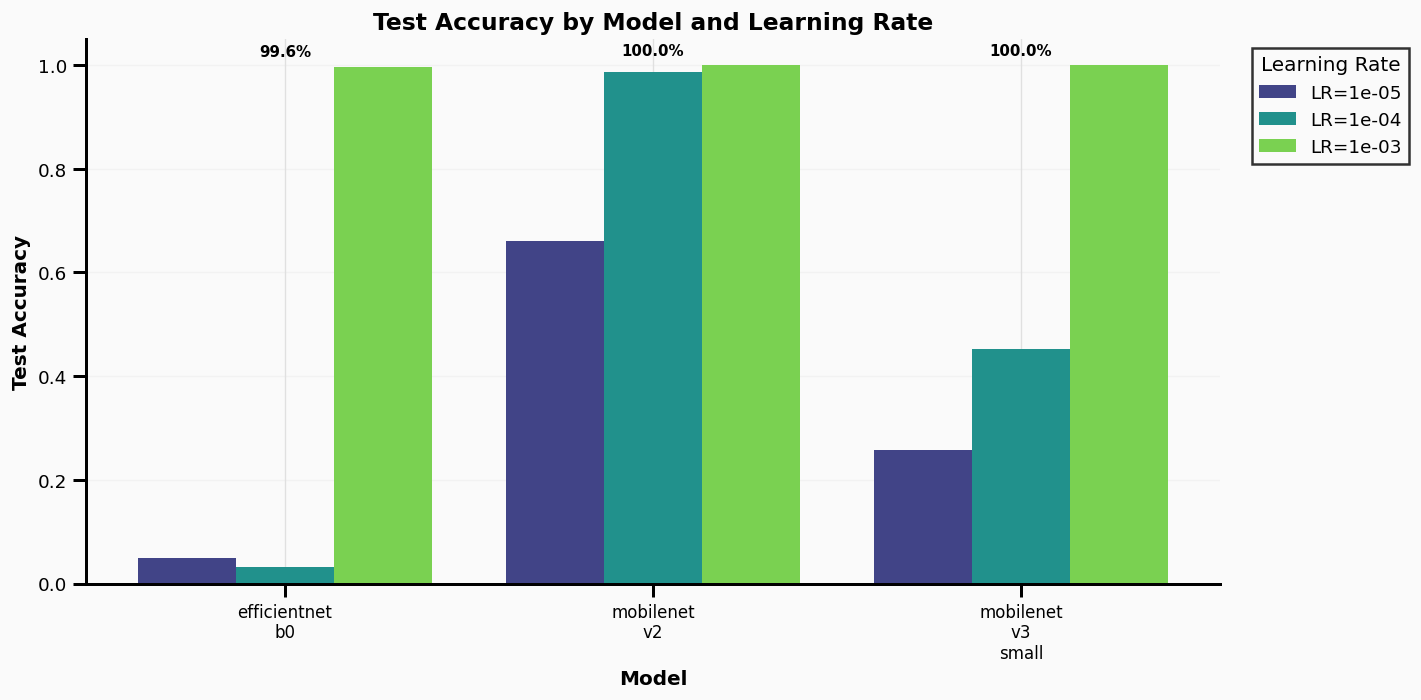

In [7]:
# Grouped bar chart: Test accuracy by model and learning rate
fig, ax = plt.subplots(figsize=(12, 6))

# Pivot data for grouped bars
models = sorted(df['model'].unique())
lrs = sorted(df['lr'].unique())

x = np.arange(len(models))
width = 0.8 / len(lrs)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(lrs)))

for i, lr in enumerate(lrs):
    lr_data = df[df['lr'] == lr]
    # Get best test_acc for each model at this LR (across batch sizes)
    accuracies = []
    for model in models:
        model_lr_data = lr_data[lr_data['model'] == model]
        if not model_lr_data.empty:
            accuracies.append(model_lr_data['test_acc'].max())
        else:
            accuracies.append(0)
    
    offset = (i - len(lrs)/2 + 0.5) * width
    bars = ax.bar(x + offset, accuracies, width, label=f'LR={lr:.0e}', color=colors[i])

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Test Accuracy by Model and Learning Rate', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', '\n') for m in models], fontsize=10)
ax.legend(title='Learning Rate', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)

# Add value labels on best bars
for model_idx, model in enumerate(models):
    best_acc = df[df['model'] == model]['test_acc'].max()
    ax.annotate(f'{best_acc:.1%}', xy=(model_idx, best_acc + 0.02), 
                ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '04-model-comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 4. Learning Rate Effect per Model

Bar chart showing test accuracy for each learning rate, separated by model.


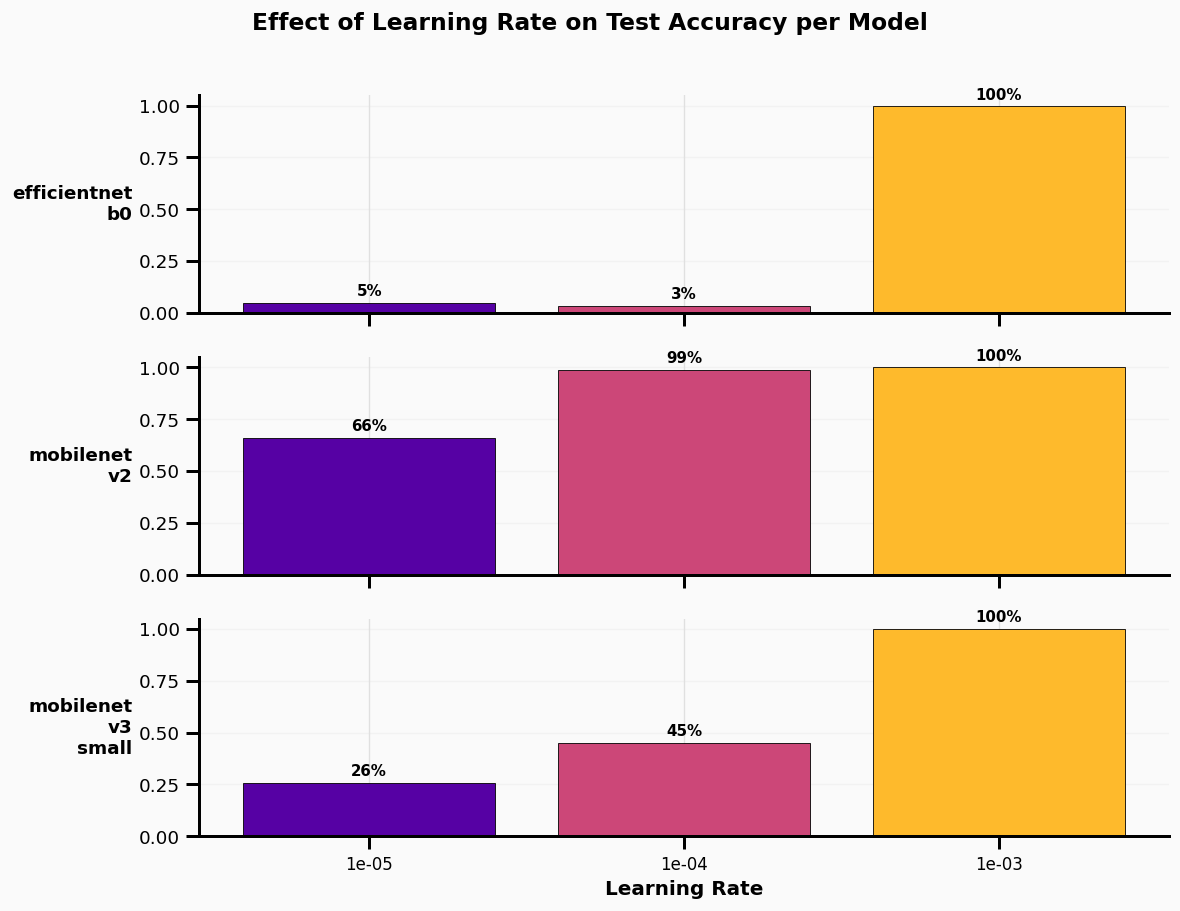

In [8]:
# Subplot: Effect of LR on each model (Test Accuracy only)
models = sorted(df['model'].unique())
lrs = sorted(df['lr'].unique())

fig, axes = plt.subplots(len(models), 1, figsize=(10, 2.5*len(models)), sharey=True)
if len(models) == 1:
    axes = [axes]

colors_lr = plt.cm.plasma(np.linspace(0.15, 0.85, len(lrs)))

for row_idx, model in enumerate(models):
    model_data = df[df['model'] == model]
    ax = axes[row_idx]
    
    test_accs = []
    lr_labels = []
    
    for lr in lrs:
        lr_data = model_data[model_data['lr'] == lr]
        if lr_data.empty:
            test_accs.append(0)
        else:
            # Get best run for this lr (by test_acc)
            test_accs.append(lr_data['test_acc'].max())
        lr_labels.append(f'{lr:.0e}')
    
    x = np.arange(len(lrs))
    bars = ax.bar(x, test_accs, color=colors_lr, edgecolor='black', linewidth=0.5)
    
    ax.set_ylabel(model.replace('_', '\n'), fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax.set_xticks(x)
    ax.set_xticklabels(lr_labels if row_idx == len(models)-1 else [], fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    # Add value labels
    for bar, val in zip(bars, test_accs):
        if val > 0:
            ax.annotate(f'{val:.0%}', xy=(bar.get_x() + bar.get_width()/2, val + 0.02), 
                       ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[-1].set_xlabel('Learning Rate', fontsize=12)
fig.suptitle('Effect of Learning Rate on Test Accuracy per Model', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '04-lr-effect-per-model.png', dpi=150, bbox_inches='tight')
plt.show()


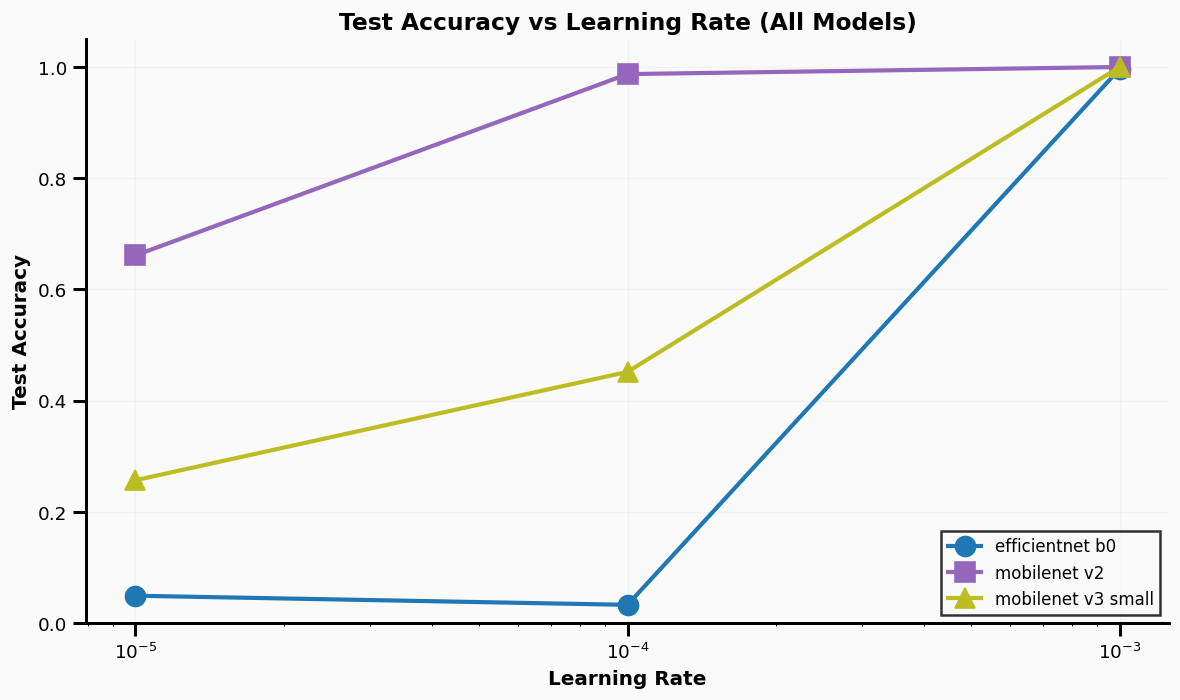

In [9]:
# Line plot: Test Accuracy trends across LRs for each model
fig, ax = plt.subplots(figsize=(10, 6))

models = sorted(df['model'].unique())
lrs = sorted(df['lr'].unique())
colors_model = plt.cm.tab10(np.linspace(0, 0.8, len(models)))
markers = ['o', 's', '^', 'D']

for i, model in enumerate(models):
    model_data = df[df['model'] == model]
    lr_vals = []
    acc_vals = []
    for lr in lrs:
        lr_data = model_data[model_data['lr'] == lr]
        if not lr_data.empty and pd.notna(lr_data['test_acc']).any():
            lr_vals.append(lr)
            acc_vals.append(lr_data['test_acc'].max())  # Best accuracy
    
    if lr_vals:
        ax.plot(lr_vals, acc_vals, marker=markers[i % len(markers)], linestyle='-', 
                color=colors_model[i], label=model.replace('_', ' '), 
                linewidth=2.5, markersize=12)

ax.set_xscale('log')
ax.set_xlabel('Learning Rate', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Test Accuracy vs Learning Rate (All Models)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '04-lr-trends.png', dpi=150, bbox_inches='tight')
plt.show()


## 5. Training Curves (Best Configurations)


C:\Users\fibla\AppData\Local\Temp\ipykernel_3400\839956796.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


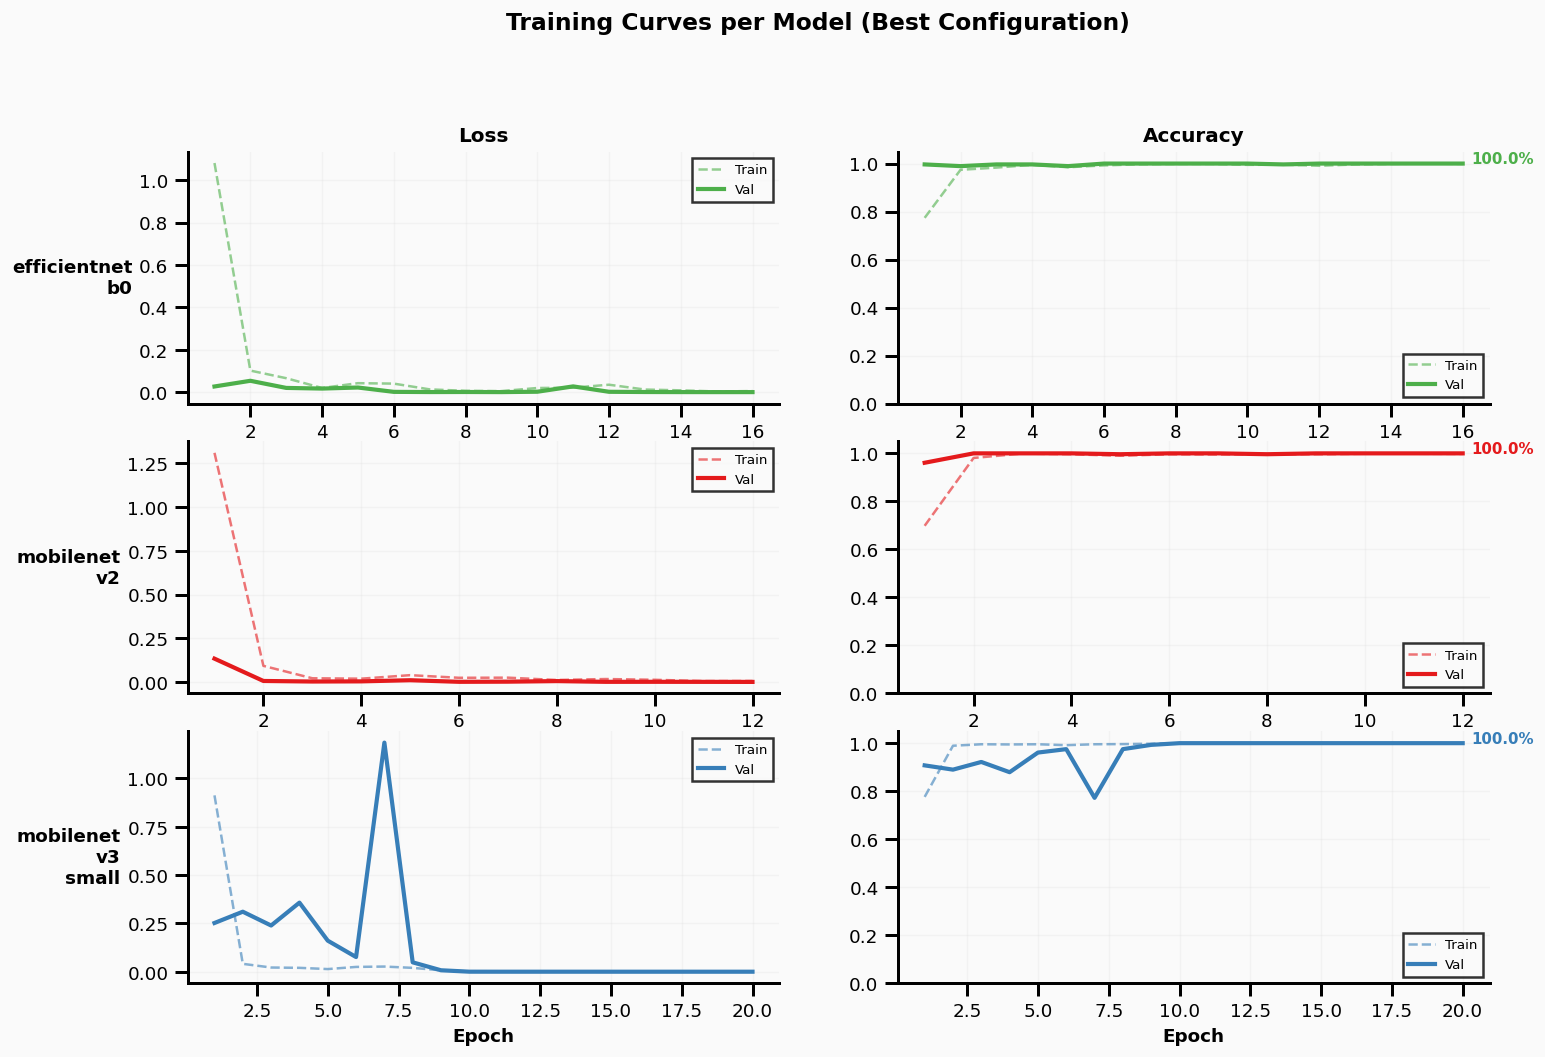

In [10]:
# Load training curves - one row per model (best run per model)
client = mlflow.tracking.MlflowClient()

# Get best run per model (unique models only)
models = sorted(df['model'].unique())
best_runs_per_model = df.loc[df.groupby('model')['test_acc'].idxmax()]

fig, axes = plt.subplots(len(models), 2, figsize=(14, 3*len(models)), 
                         gridspec_kw={'hspace': 0.15, 'wspace': 0.2})

colors = {'mobilenet_v2': '#e41a1c', 'mobilenet_v3_small': '#377eb8', 
          'efficientnet_b0': '#4daf4a', 'resnet18': '#984ea3'}

for idx, (_, run) in enumerate(best_runs_per_model.iterrows()):
    run_id = run['run_id']
    model_name = run['model']
    color = colors.get(model_name, '#333333')
    
    ax_loss = axes[idx, 0]
    ax_acc = axes[idx, 1]
    
    # Get metric history
    try:
        train_loss_hist = client.get_metric_history(run_id, 'train_loss')
        val_loss_hist = client.get_metric_history(run_id, 'val_loss')
        train_acc_hist = client.get_metric_history(run_id, 'train_acc')
        val_acc_hist = client.get_metric_history(run_id, 'val_acc')
        
        if train_loss_hist:
            epochs = [m.step for m in sorted(train_loss_hist, key=lambda x: x.step)]
            train_loss = [m.value for m in sorted(train_loss_hist, key=lambda x: x.step)]
            val_loss = [m.value for m in sorted(val_loss_hist, key=lambda x: x.step)]
            train_acc = [m.value for m in sorted(train_acc_hist, key=lambda x: x.step)]
            val_acc = [m.value for m in sorted(val_acc_hist, key=lambda x: x.step)]
            
            # Loss plot
            ax_loss.plot(epochs, train_loss, '--', color=color, alpha=0.6, linewidth=1.5, label='Train')
            ax_loss.plot(epochs, val_loss, '-', color=color, linewidth=2.5, label='Val')
            ax_loss.set_ylabel(model_name.replace('_', '\n'), fontsize=11, fontweight='bold', 
                              rotation=0, ha='right', va='center')
            ax_loss.grid(True, alpha=0.3)
            ax_loss.legend(loc='upper right', fontsize=8)
            if idx == 0:
                ax_loss.set_title('Loss', fontsize=12, fontweight='bold')
            if idx == len(models) - 1:
                ax_loss.set_xlabel('Epoch', fontsize=11)
            
            # Accuracy plot
            ax_acc.plot(epochs, train_acc, '--', color=color, alpha=0.6, linewidth=1.5, label='Train')
            ax_acc.plot(epochs, val_acc, '-', color=color, linewidth=2.5, label='Val')
            ax_acc.set_ylim(0, 1.05)
            ax_acc.grid(True, alpha=0.3)
            ax_acc.legend(loc='lower right', fontsize=8)
            if idx == 0:
                ax_acc.set_title('Accuracy', fontsize=12, fontweight='bold')
            if idx == len(models) - 1:
                ax_acc.set_xlabel('Epoch', fontsize=11)
                
            # Add final accuracy annotation
            final_acc = val_acc[-1] if val_acc else 0
            ax_acc.annotate(f'{final_acc:.1%}', xy=(epochs[-1], final_acc), 
                           xytext=(5, 0), textcoords='offset points',
                           fontsize=9, fontweight='bold', color=color)
    except Exception as e:
        print(f"Could not load metrics for {model_name} ({run_id}): {e}")
        ax_loss.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax_loss.transAxes)
        ax_acc.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax_acc.transAxes)

fig.suptitle('Training Curves per Model (Best Configuration)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '04-training-curves.png', dpi=150, bbox_inches='tight')
plt.show()


## 6. Sample Predictions with Confidence


In [11]:
# Load best model
best_run = df.loc[df['test_acc'].idxmax()]
best_run_id = best_run['run_id']
best_model_name = best_run['model']

print(f"Loading best model: {best_model_name}")
print(f"Run ID: {best_run_id}")

# Find checkpoint in MLflow artifacts
mlruns_dir = MODELS_DIR / 'mlruns'
checkpoint_path = None

for exp_dir in mlruns_dir.iterdir():
    if exp_dir.is_dir() and exp_dir.name not in ['0', 'models']:
        run_dir = exp_dir / best_run_id / 'artifacts' / 'checkpoints'
        if run_dir.exists():
            checkpoint_files = list(run_dir.glob("*.pth"))
            if checkpoint_files:
                checkpoint_path = sorted(checkpoint_files)[-1]
                break

if checkpoint_path:
    print(f"Loading checkpoint: {checkpoint_path.name}")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
    
    num_classes = checkpoint.get('num_classes', 26)
    classes = checkpoint.get('classes', [chr(ord('a') + i) for i in range(26)])
    
    model = get_model(best_model_name, num_classes, pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(DEVICE)
    model.eval()
    print(f"✅ Model loaded! Classes: {len(classes)}")
else:
    print("❌ Could not find checkpoint")


Loading best model: mobilenet_v3_small
Run ID: d4f96492d7224d4ba0f75676c44bcaca
Loading checkpoint: mobilenet_v3_small_v1_acc1.00_20251127_211125.pth
✅ Model loaded! Classes: 26


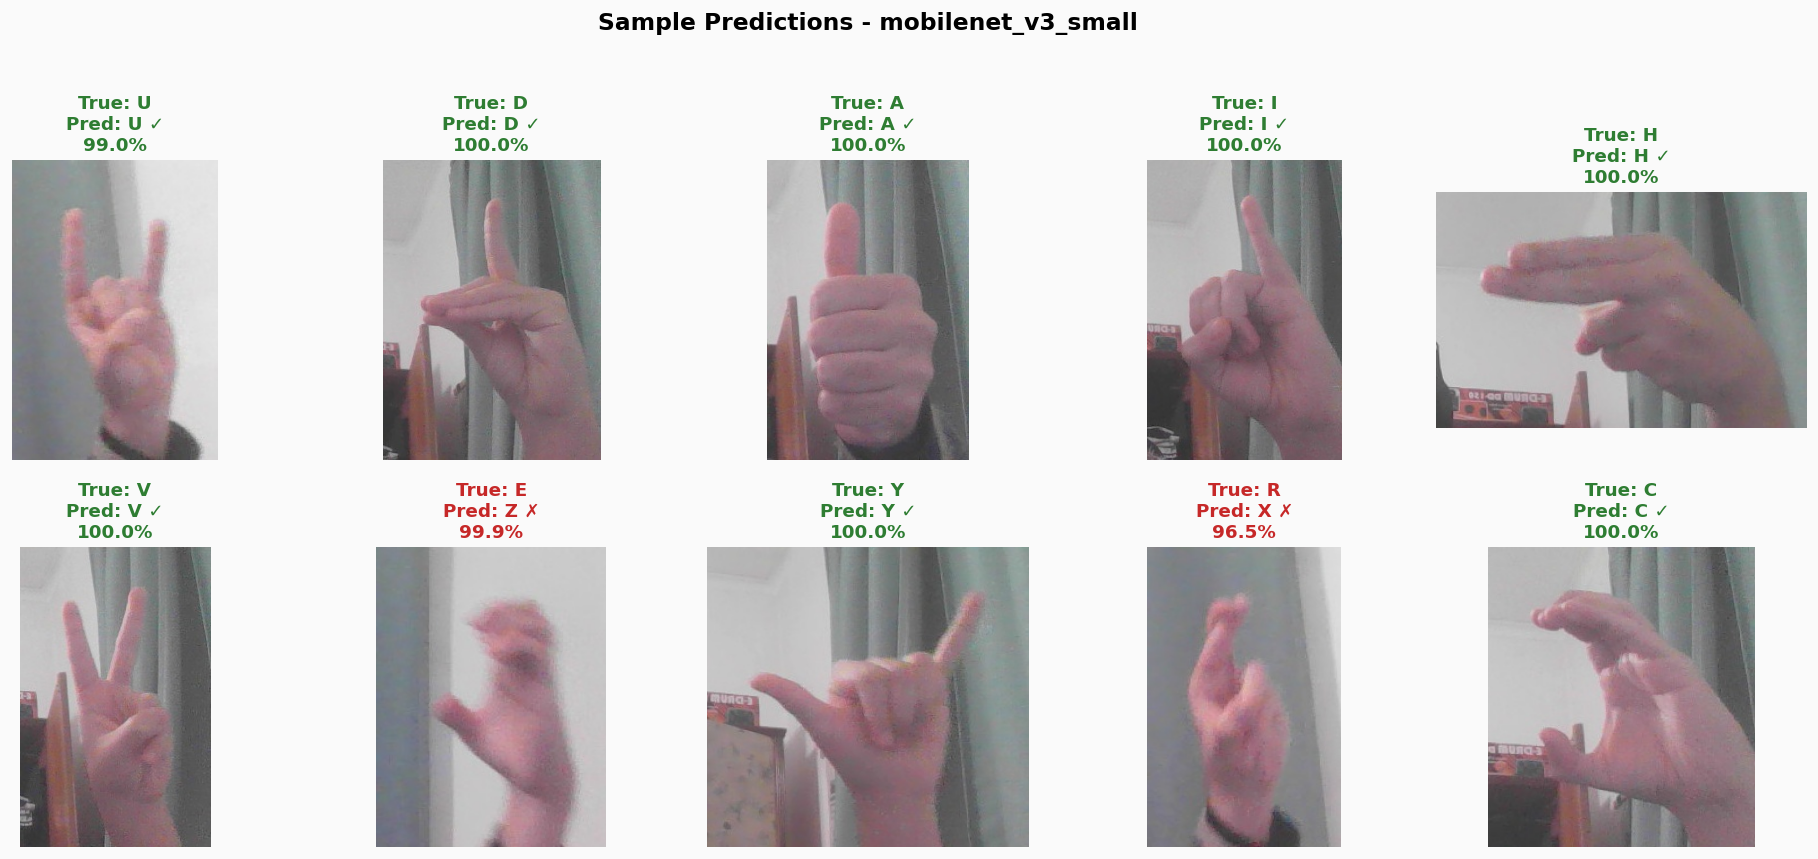

In [12]:
# Sample predictions with confidence visualization
import random
random.seed(42)

transform = get_inference_transform()

# Get sample images from different classes
sample_letters = random.sample(classes, min(10, len(classes)))
samples = []

for letter in sample_letters:
    letter_dir = DATA_DIR / letter
    if letter_dir.exists():
        img_paths = list(letter_dir.glob('*.jpg'))
        if img_paths:
            img_path = random.choice(img_paths)
            samples.append((letter, img_path))

# Make predictions
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
axes = axes.flatten()

for ax, (true_label, img_path) in zip(axes, samples):
    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')
    tensor = transform(np.array(img)).unsqueeze(0).to(DEVICE)
    
    # Predict
    with torch.no_grad():
        output = model(tensor)
        probs = F.softmax(output, dim=1)
        conf, pred_idx = probs.max(1)
        pred_label = classes[pred_idx.item()]
        confidence = conf.item()
    
    # Display image
    ax.imshow(img)
    ax.axis('off')
    
    # Title with result
    is_correct = pred_label == true_label
    color = '#2e7d32' if is_correct else '#c62828'
    symbol = '✓' if is_correct else '✗'
    ax.set_title(f"True: {true_label.upper()}\nPred: {pred_label.upper()} {symbol}\n{confidence:.1%}", 
                 fontsize=11, color=color, fontweight='bold')

# Remove empty subplots
for i in range(len(samples), len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Sample Predictions - {best_model_name}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '04-sample-predictions.png', dpi=150, bbox_inches='tight')
plt.show()


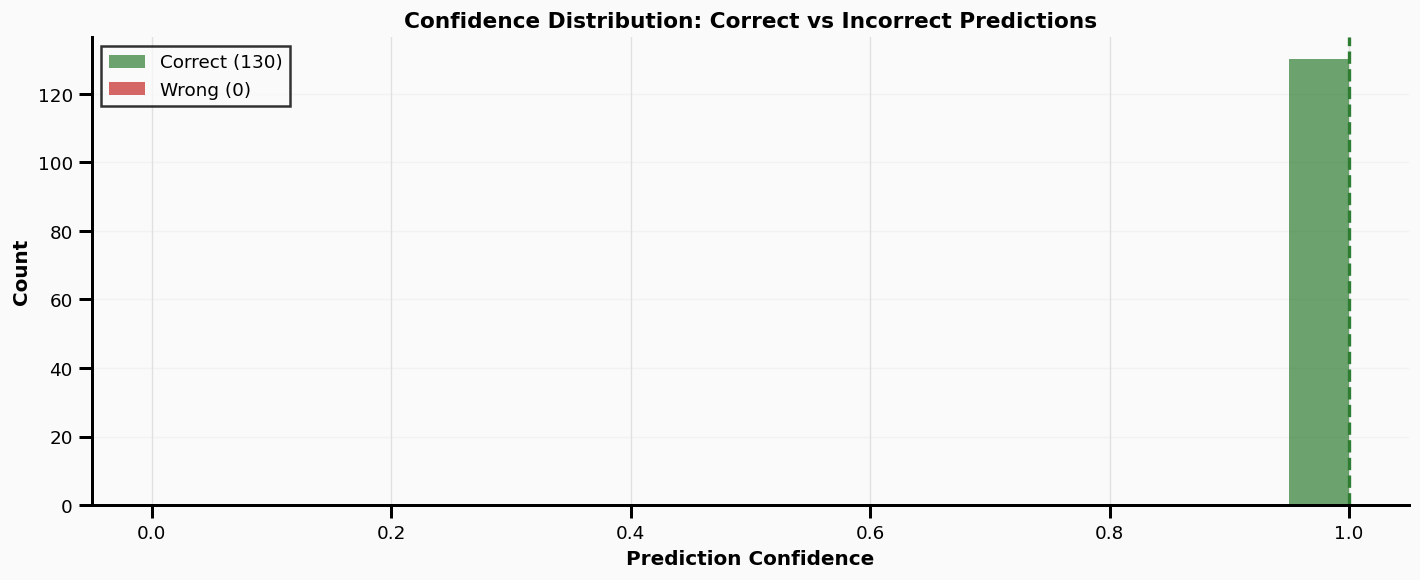


Accuracy on sampled images: 100.0%
Average confidence (correct): 100.0%


In [ ]:
## 7. Confusion Matrix Analysis


In [ ]:
# Generate confusion matrix using the loaded best model
from sklearn.metrics import confusion_matrix, classification_report
from src.cv_model.preprocessing import create_dataloaders

# Create test dataloader
_, _, test_loader, num_classes, class_names = create_dataloaders(
    data_dir=DATA_DIR,
    batch_size=32
)

# Collect predictions
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = probs.max(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f"Test set size: {len(all_labels)}")
print(f"Overall accuracy: {(all_preds == all_labels).mean():.2%}")


In [ ]:
# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)
ax.set_title(f'Confusion Matrix - {best_model_name}\n(Test Set Accuracy: {(all_preds == all_labels).mean():.1%})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / '04-confusion-matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Print classification report
print("\nPer-Class Performance:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))


Loaded 3658 images from 26 classes
Split sizes - Train: 2560, Val: 549, Test: 549
Loaded 3658 images from 26 classes
Loaded 3658 images from 26 classes
Loaded 3658 images from 26 classes
Test set size: 549
Overall accuracy: 73.41%


## 8. Error Case Analysis

#Examining misclassified samples to understand failure patterns.


In [19]:
# Find misclassified samples
error_indices = np.where(all_preds != all_labels)[0]
print(f"Total errors: {len(error_indices)} out of {len(all_labels)} ({len(error_indices)/len(all_labels):.1%})")

if len(error_indices) > 0:
    # Get error details
    error_info = []
    for idx in error_indices:
        error_info.append({
            'true': class_names[all_labels[idx]],
            'pred': class_names[all_preds[idx]],
            'confidence': all_probs[idx][all_preds[idx]],
            'idx': idx
        })
    
    # Show error summary
    print("\nMost common confusions:")
    confusion_pairs = {}
    for e in error_info:
        pair = f"{e['true'].upper()} → {e['pred'].upper()}"
        confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1
    
    for pair, count in sorted(confusion_pairs.items(), key=lambda x: -x[1])[:10]:
        print(f"  {pair}: {count} times")
else:
    print("\n✅ No errors found! Model achieved perfect accuracy on test set.")


Total errors: 146 out of 549 (26.6%)

Most common confusions:
  R → Z: 14 times
  N → Z: 10 times
  F → Z: 9 times
  B → X: 7 times
  C → Z: 6 times
  P → Z: 6 times
  Q → Z: 6 times
  N → S: 4 times
  S → Z: 4 times
  I → Z: 4 times


Loaded 3658 images from 26 classes
Split sizes - Train: 2560, Val: 549, Test: 549
Loaded 3658 images from 26 classes
Loaded 3658 images from 26 classes
Loaded 3658 images from 26 classes


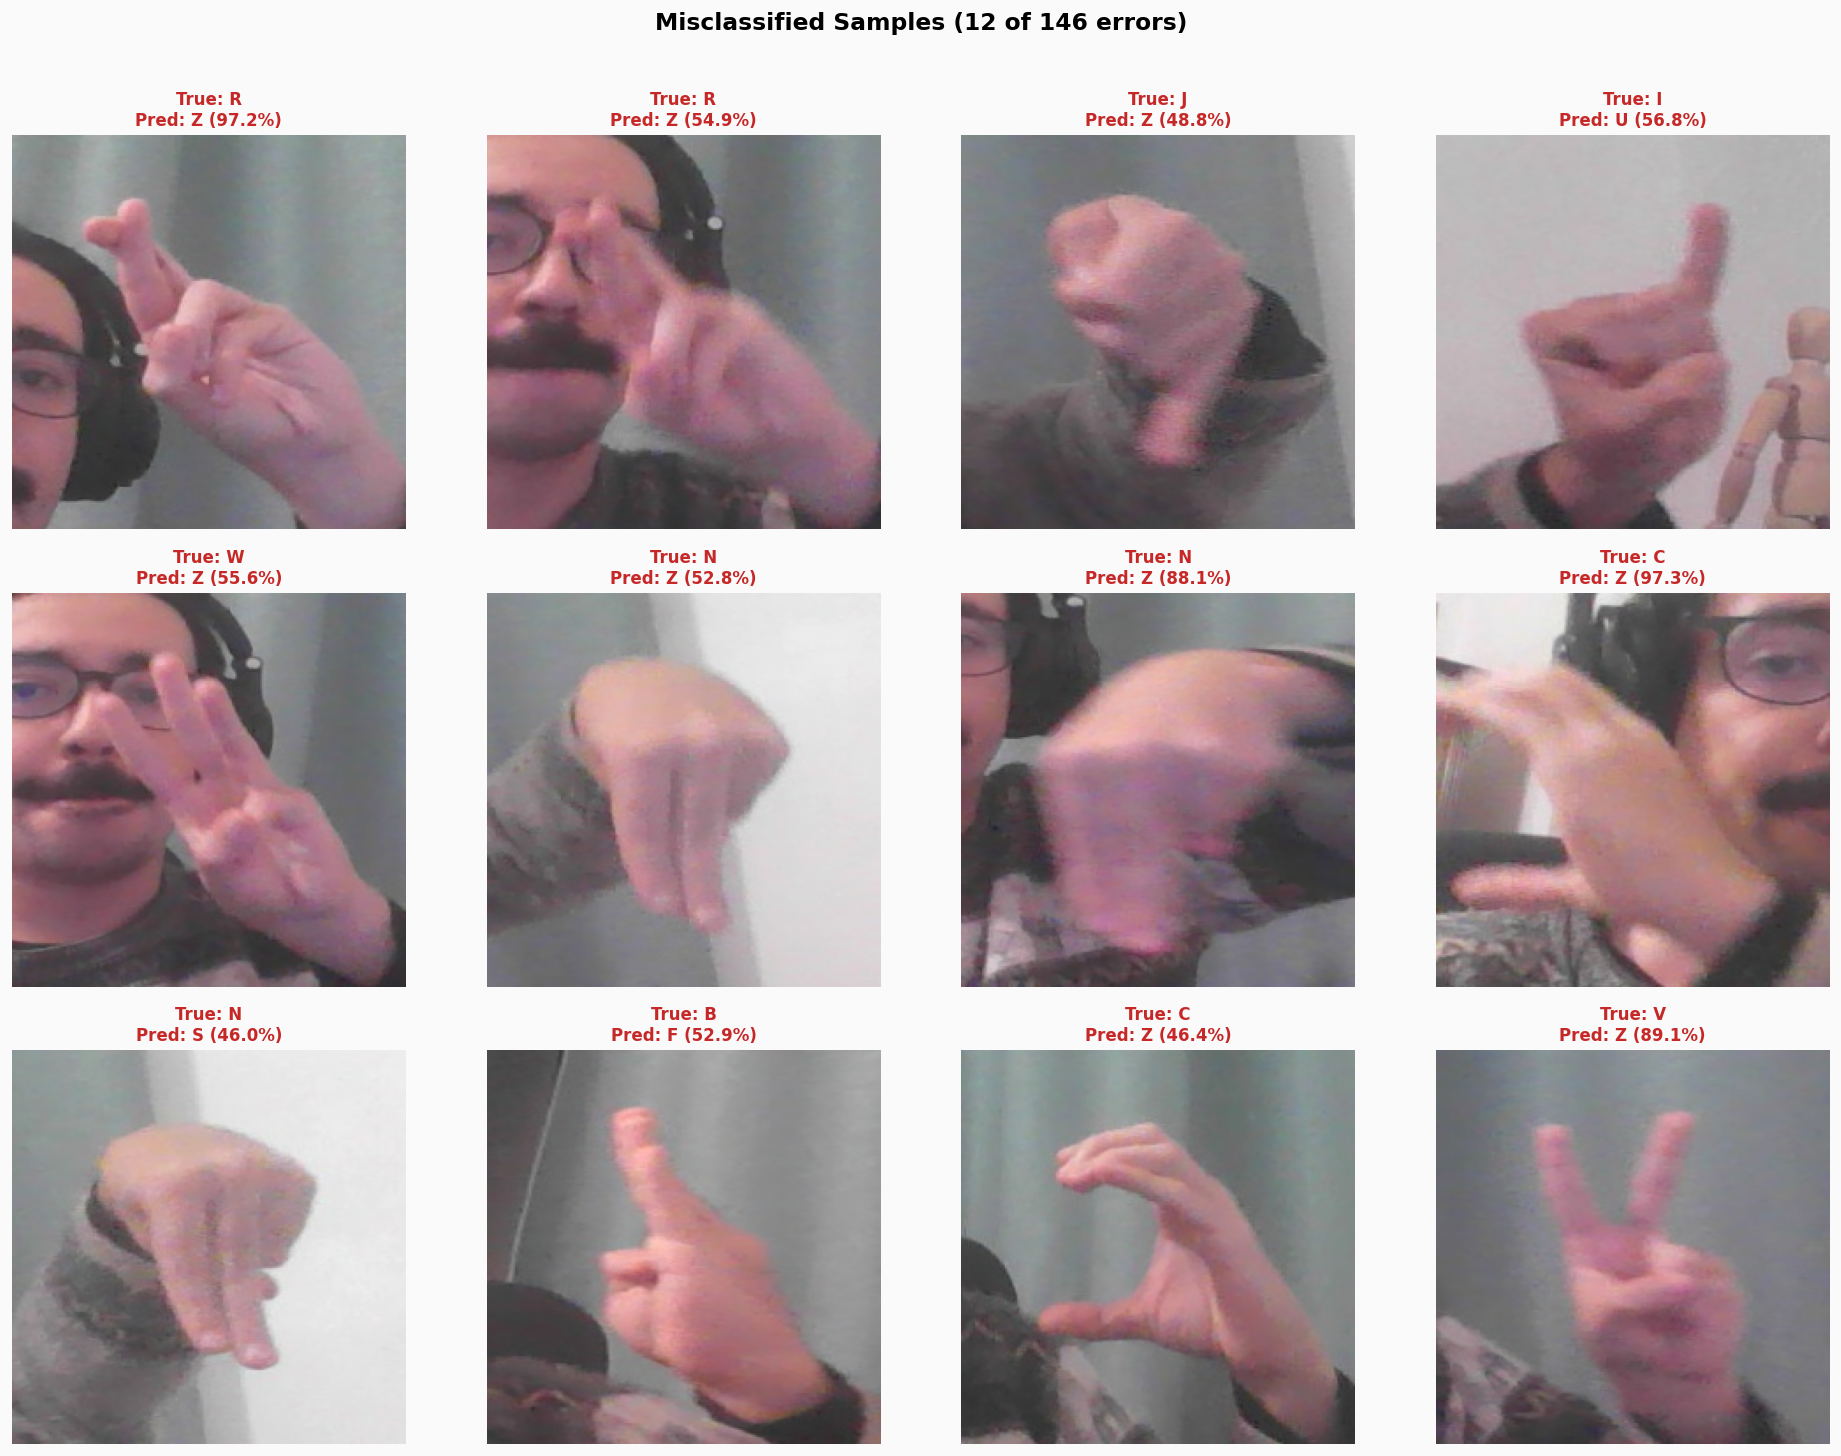

In [20]:
# Visualize error cases (if any exist)
if len(error_indices) > 0:
    # Recreate dataloader to get images
    _, _, test_loader_viz, _, _ = create_dataloaders(data_dir=DATA_DIR, batch_size=1)
    
    # Collect all test images
    test_images_list = []
    for img, _ in test_loader_viz:
        test_images_list.append(img.squeeze(0))
    
    # Select up to 12 error cases to display
    num_errors_to_show = min(12, len(error_indices))
    sample_errors = error_indices[:num_errors_to_show]
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    # Denormalization for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    for ax_idx, err_idx in enumerate(sample_errors):
        ax = axes[ax_idx]
        
        # Get image and denormalize
        img_tensor = test_images_list[err_idx]
        img_denorm = img_tensor * std + mean
        img_np = img_denorm.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)
        
        ax.imshow(img_np)
        ax.axis('off')
        
        true_label = class_names[all_labels[err_idx]]
        pred_label = class_names[all_preds[err_idx]]
        conf = all_probs[err_idx][all_preds[err_idx]]
        
        ax.set_title(f"True: {true_label.upper()}\nPred: {pred_label.upper()} ({conf:.1%})", 
                    fontsize=10, color='#c62828', fontweight='bold')
    
    # Hide unused subplots
    for ax_idx in range(num_errors_to_show, len(axes)):
        axes[ax_idx].axis('off')
    
    plt.suptitle(f'Misclassified Samples ({num_errors_to_show} of {len(error_indices)} errors)', 
                 fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / '04-error-cases.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No error cases to visualize - model achieved perfect accuracy!")


Loaded 3658 images from 26 classes
Split sizes - Train: 2560, Val: 549, Test: 549
Loaded 3658 images from 26 classes
Loaded 3658 images from 26 classes
Loaded 3658 images from 26 classes


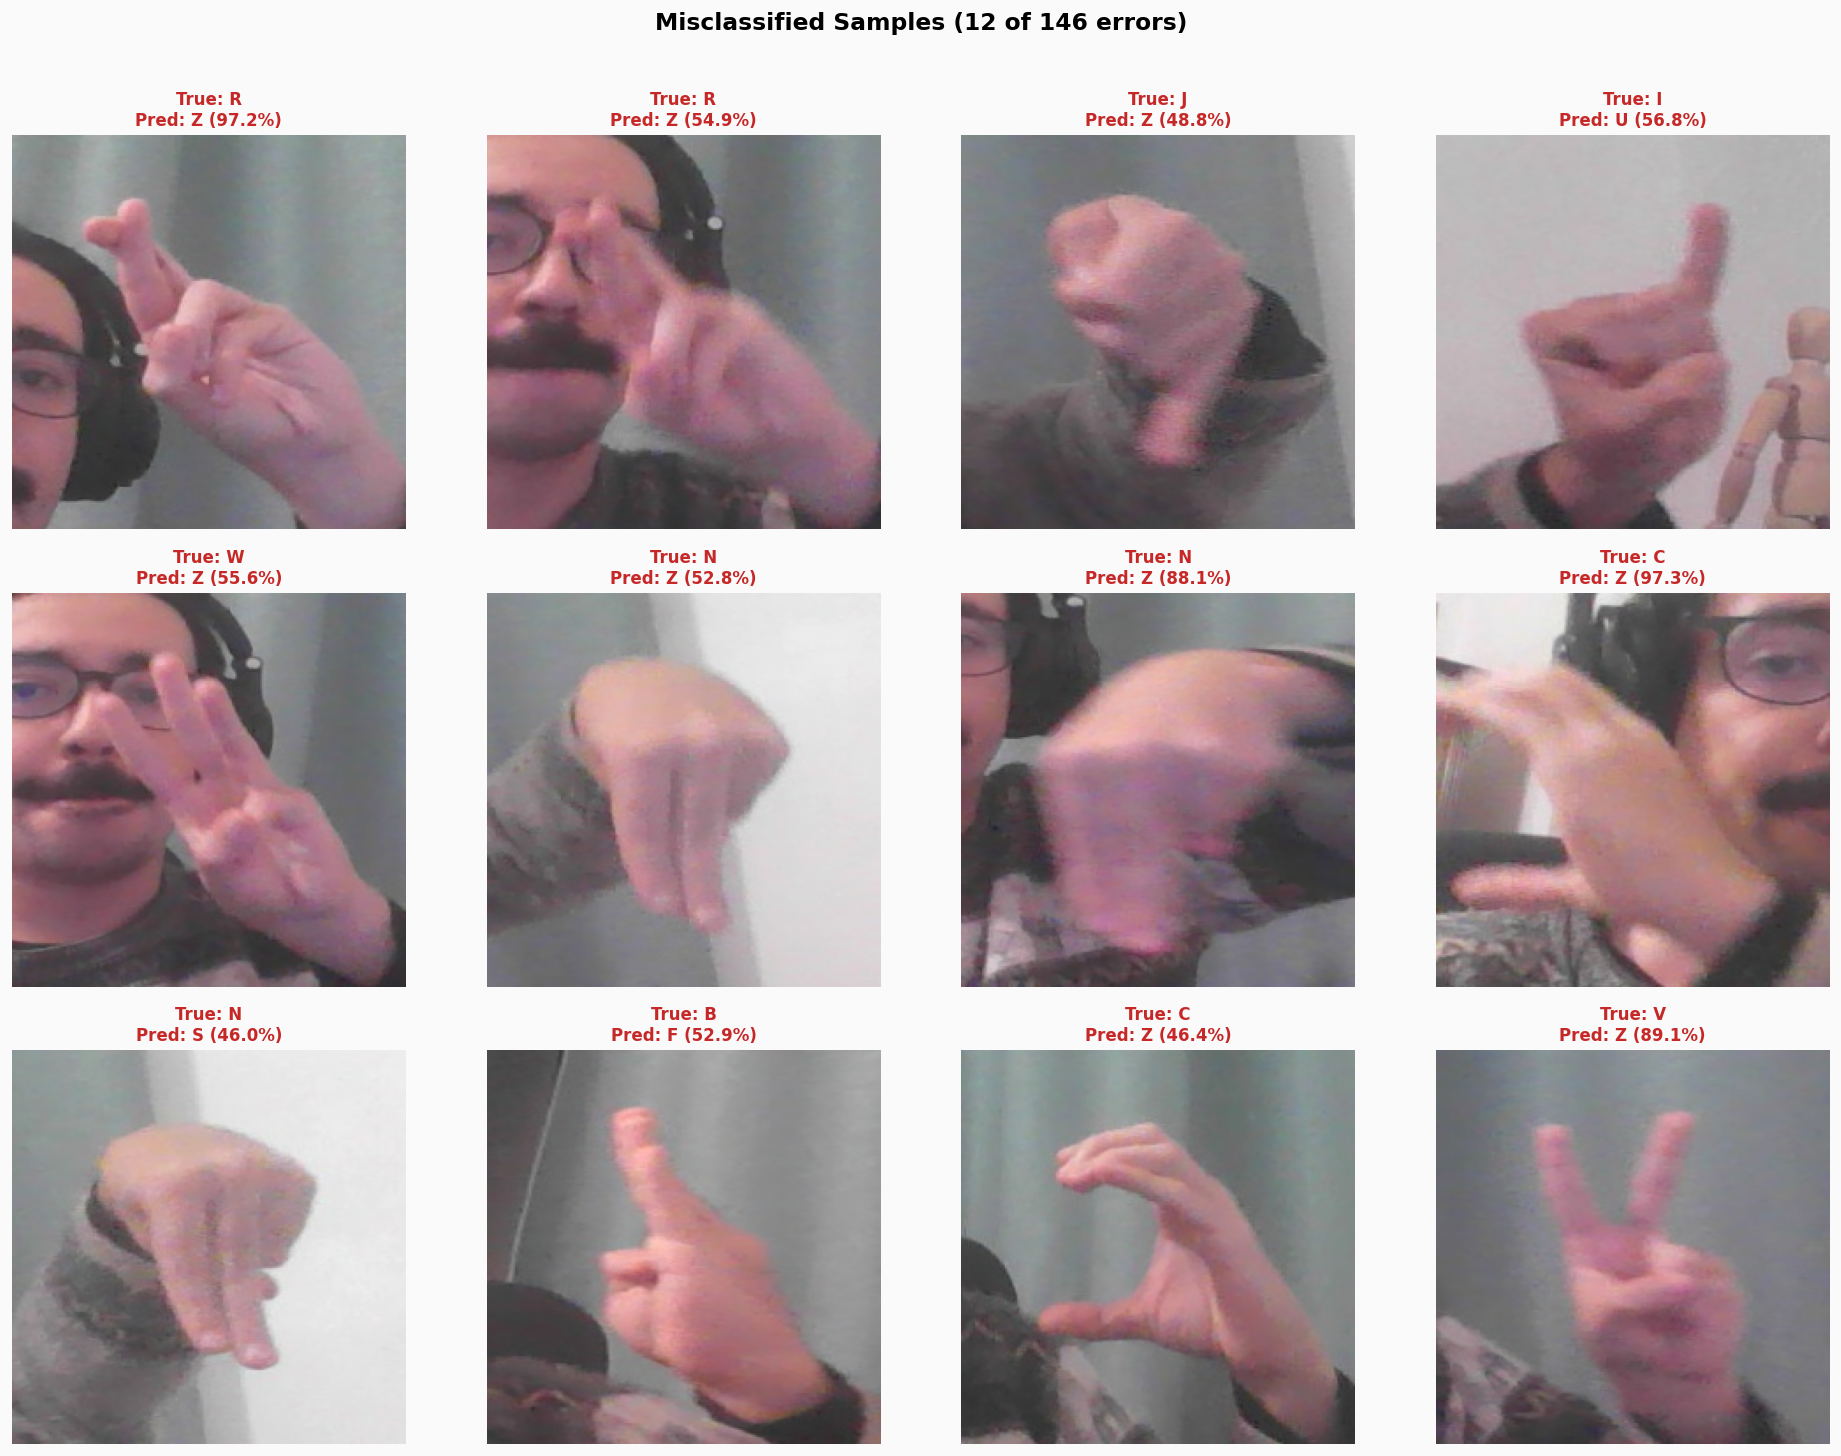

In [ ]:
## 9. Key Takeaways


In [21]:
print("=" * 70)
print("KEY TAKEAWAYS FROM HYPERPARAMETER SEARCH")
print("=" * 70)

# Best overall
best = df.loc[df['test_acc'].idxmax()]
print(f"\n🏆 BEST CONFIGURATION:")
print(f"   Model: {best['model']}")
print(f"   Learning Rate: {best['lr']:.0e}")
print(f"   Batch Size: {best['batch_size']}")
print(f"   Test Accuracy: {best['test_acc']:.2%}")

# Model ranking
print(f"\n📊 MODEL RANKING (by best test accuracy):")
model_ranking = df.groupby('model')['test_acc'].max().sort_values(ascending=False)
for i, (model_name, acc) in enumerate(model_ranking.items(), 1):
    print(f"   {i}. {model_name}: {acc:.2%}")

# LR insights
print(f"\n📈 LEARNING RATE INSIGHTS:")
lr_ranking = df.groupby('lr')['test_acc'].mean().sort_values(ascending=False)
for lr, acc in lr_ranking.items():
    print(f"   LR={lr:.0e}: avg test acc = {acc:.2%}")

# Summary statistics
print(f"\n📋 SUMMARY:")
print(f"   Total experiments: {len(df)}")
print(f"   Best test accuracy: {df['test_acc'].max():.2%}")
print(f"   Worst test accuracy: {df['test_acc'].min():.2%}")
print(f"   Mean test accuracy: {df['test_acc'].mean():.2%}")

print("\n" + "=" * 70)


KEY TAKEAWAYS FROM HYPERPARAMETER SEARCH

🏆 BEST CONFIGURATION:
   Model: mobilenet_v3_small
   Learning Rate: 1e-03
   Batch Size: 32
   Test Accuracy: 100.00%

📊 MODEL RANKING (by best test accuracy):
   1. mobilenet_v2: 100.00%
   2. mobilenet_v3_small: 100.00%
   3. efficientnet_b0: 99.64%

📈 LEARNING RATE INSIGHTS:
   LR=1e-03: avg test acc = 73.47%
   LR=1e-04: avg test acc = 47.30%
   LR=1e-05: avg test acc = 25.87%

📋 SUMMARY:
   Total experiments: 21
   Best test accuracy: 100.00%
   Worst test accuracy: 2.55%
   Mean test accuracy: 52.39%

